In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot4 as uproot
import scipy.stats
import sklearn
from sklearn import linear_model
from scipy import optimize
import warnings; warnings.simplefilter('ignore')

In [2]:
def get_gaussian_std(prediction,energy_bin_centers,oa_events):
    gfit = optimize.curve_fit(gaussian,energy_bin_centers,prediction)[0]
    loc,scale = gfit[0],gfit[1]
    return scale

def gaussian(x,loc,scale):
    with uproot.open("Fluxes.ND.root") as fFluxes :
        oa_flux = fFluxes['LBNF_numu_flux'].values()
        energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
        angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
    rescaling = oa_flux.max()
    return (1/(scale*((2*np.pi)**0.5)))*np.exp((-((x-loc)/scale)**2)/2)*rescaling

In [116]:
'''
loc = Center of the gaussian in GeV
scale = RMS of the gaussian in GeV
model = Regression model; default (Ridge) = Tikhonov
alpha = Regularisation parameter
'''

loc = 1.
scale =  0.07
model = sklearn.linear_model.Ridge
alpha = 0 #0 for paper plot; 1e12 for

In [117]:
# Get DUNE near detector muon neutrino flux as a function of off-axis angle
with uproot.open("Fluxes.ND.root") as fFluxes :
    oa_flux = fFluxes['LBNF_numu_flux'].values()
    energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
    angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
energy_bin_centers = np.add(energy_bins[:-1], energy_bins[1:])/2.
    
# Define target flux
target_loc = loc
target_scale = scale 
rescaling = oa_flux.max()
target_flux = [scipy.stats.norm.pdf(x, loc = target_loc, scale = target_scale)*rescaling for x in energy_bin_centers] #here we should scale the gaussian
target_flux = np.array(target_flux)

# Calculate coefficients
if (model == None):
    x , residuals, rank, s = np.linalg.lstsq(oa_flux, target_flux, rcond=None)
    print("none")
else:
    lm = model(alpha=alpha,fit_intercept=False)
    lm.fit(oa_flux,target_flux)
    x = lm.coef_
    
print("Gaussian width: " + str(get_gaussian_std(lm.predict(oa_flux),energy_bin_centers,oa_flux)))

Gaussian width: 0.07283571328814965


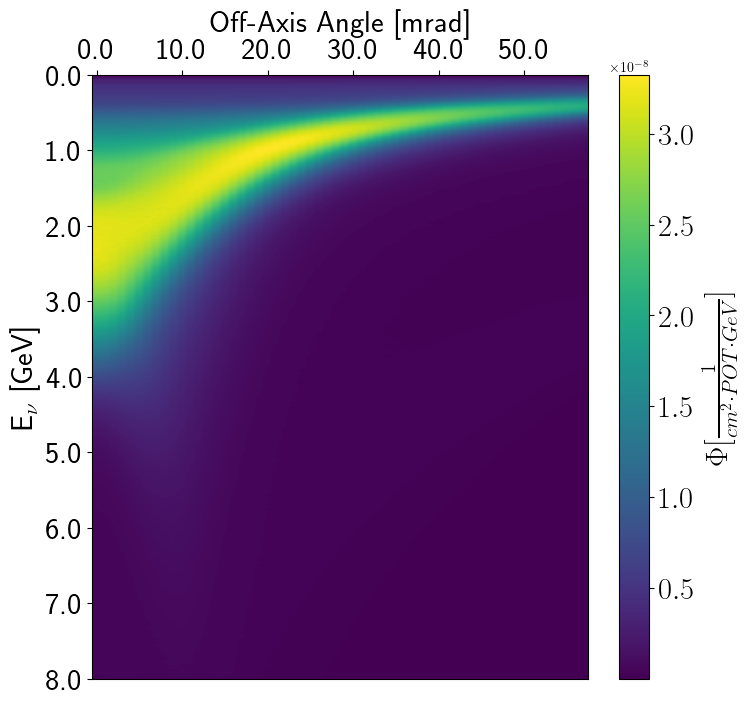

In [118]:
import matplotlib.pyplot as plt

# Set parameters
presentation_size = 22
norm = 277.6211684601875
dpi_value = 100
figsize_value = (8, 8)

# Create figure and axis
fig, ax = plt.subplots(figsize=figsize_value, dpi=dpi_value)

# Plot the flux matrix
im = ax.imshow(oa_flux[::-1]/norm, aspect="auto", origin='lower',
               extent=[angle_bins[0], angle_bins[-1], energy_bins[-1], energy_bins[0]])

# Set labels and font size
ax.set_xlabel("Off-Axis Angle [mrad]", fontsize=presentation_size)
ax.xaxis.set_label_position('top')  # Move the label to the top
ax.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticklabels(ax.get_xticks(), fontsize=presentation_size)
ax.set_yticklabels(ax.get_yticks(), fontsize=presentation_size)
ax.set_ylabel(r"E$_{\nu}$ [GeV]", fontsize=presentation_size)

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\Phi [\frac{1}{cm^2\cdot POT\cdot GeV}]$', size=presentation_size)
cbar.ax.tick_params(labelsize=presentation_size)

plt.show()

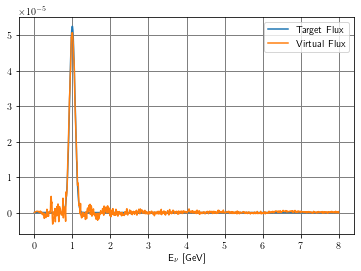

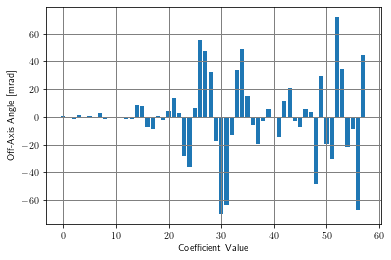

In [119]:
# Plot target flux, virtual flux
plt.plot(energy_bin_centers, target_flux, label = "Target Flux")
plt.plot(energy_bin_centers, lm.predict(oa_flux), label = "Virtual Flux")
plt.xlabel(r"E$_{\nu}$ [GeV]")

plt.legend();
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-")
plt.show()

# Plot coefficients
plt.bar(list(range(58)),x)
plt.xlabel("Coefficient Value")
plt.ylabel("Off-Axis Angle [mrad]")
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-")
plt.show()

# Paper plot (figure 1) - requires setting alpha = 0 earlier

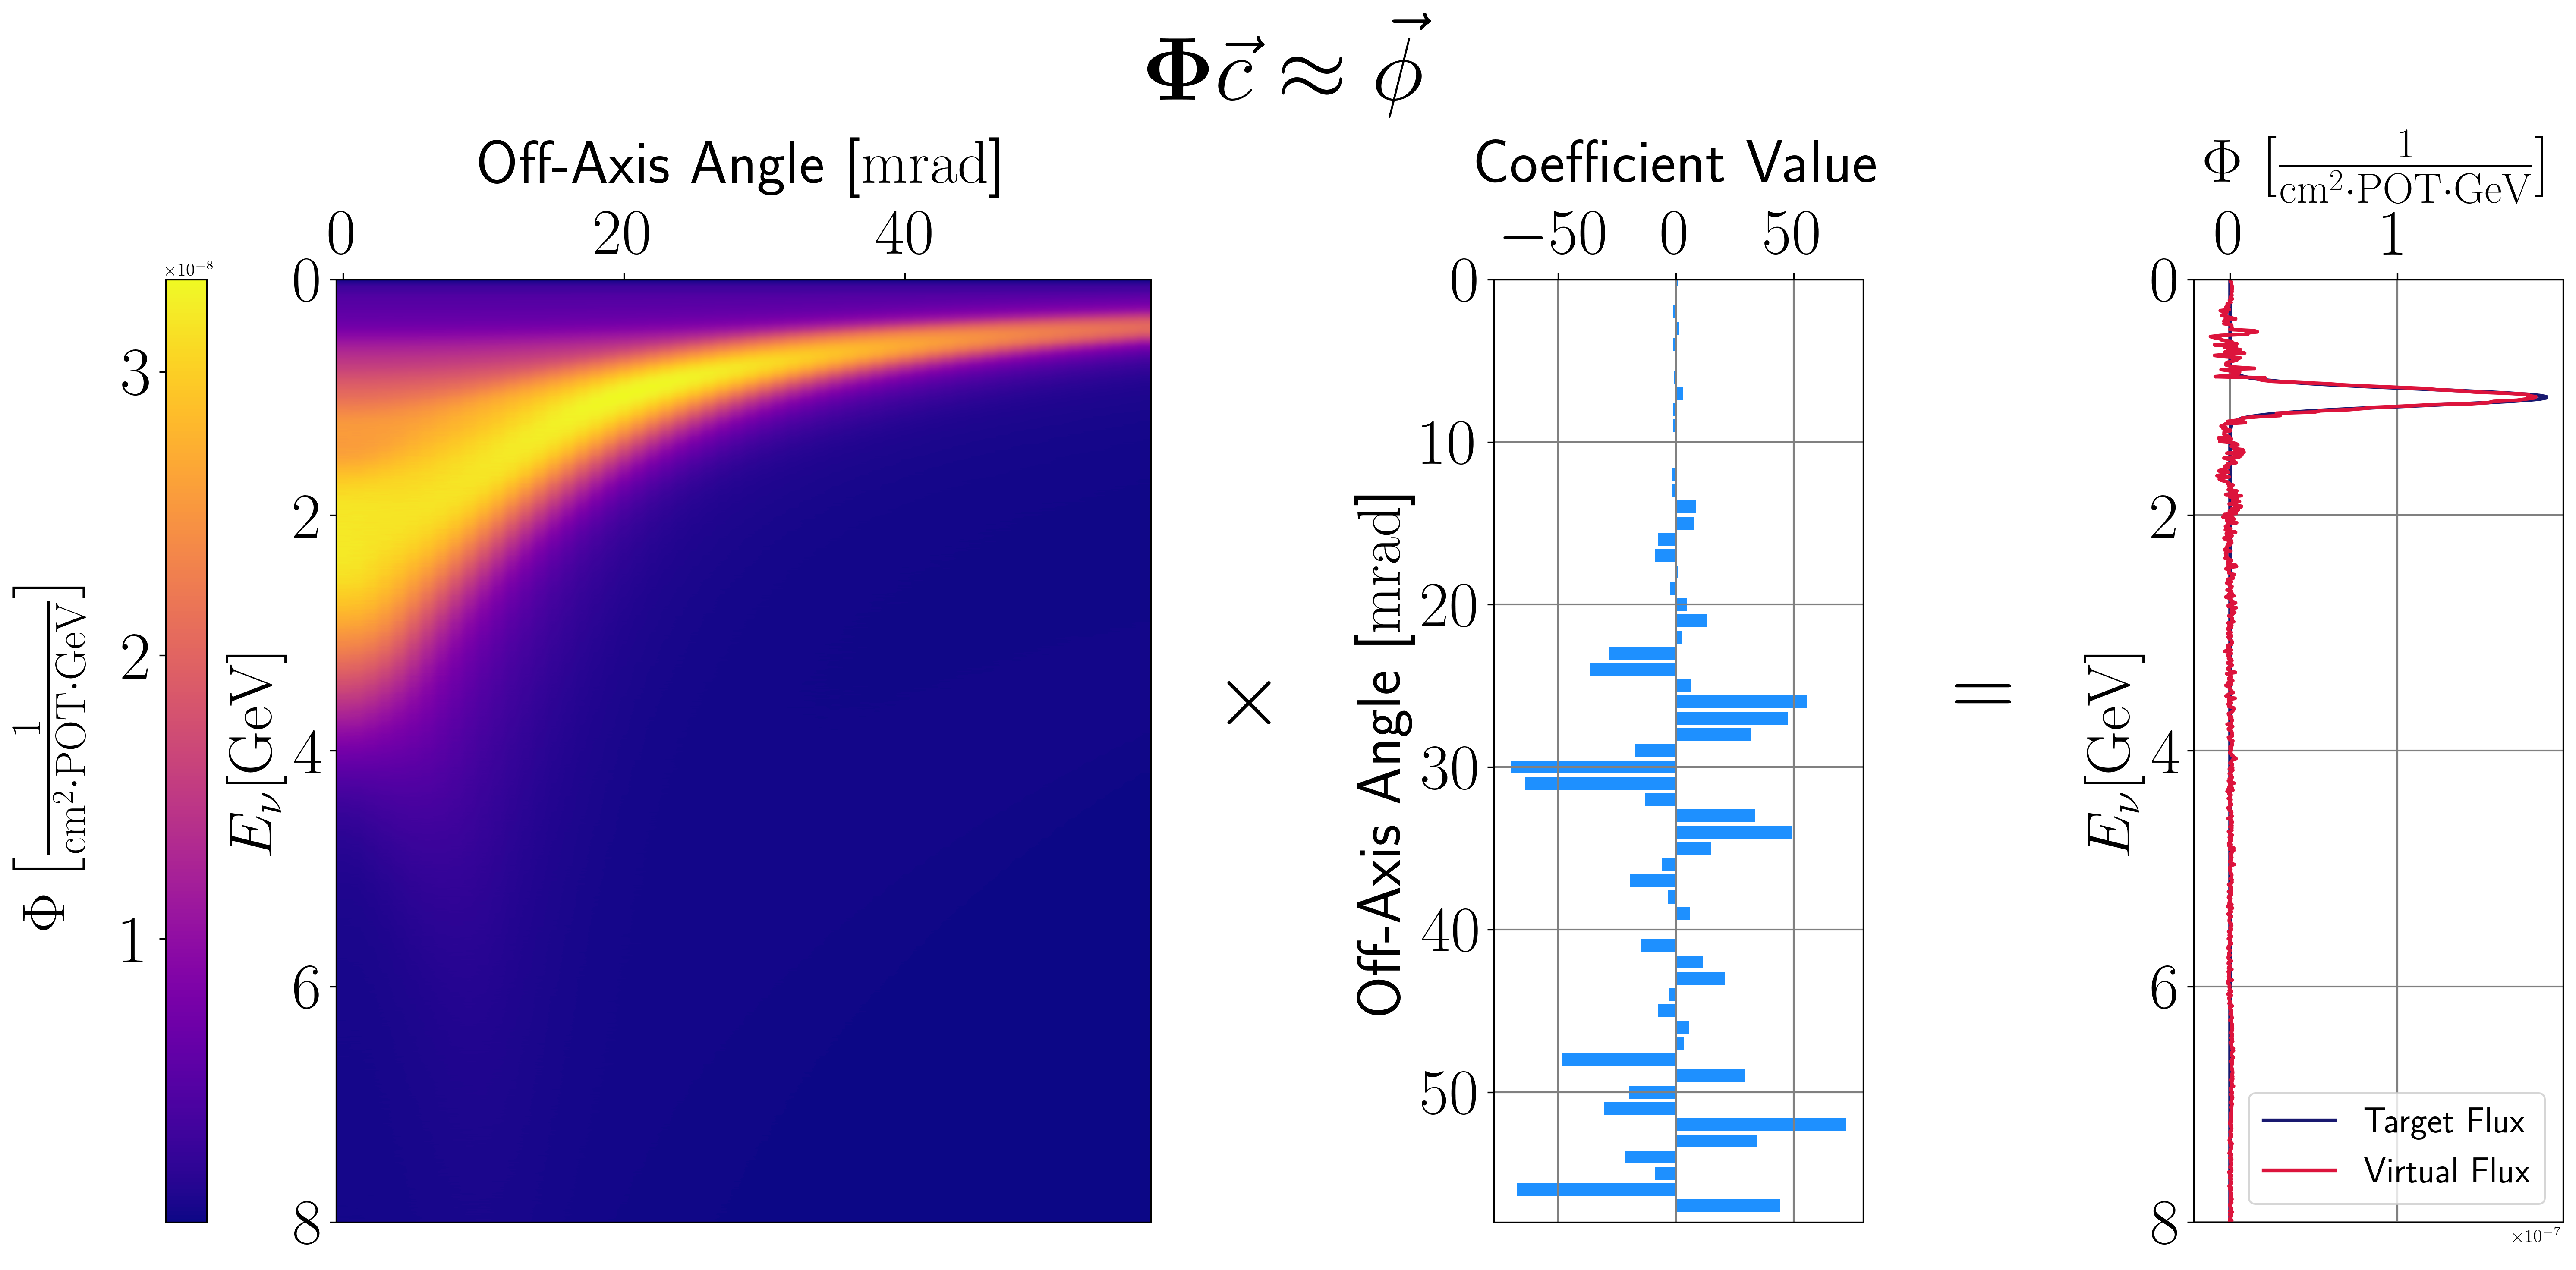

In [121]:
plt.rcParams['text.usetex'] = True
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set parameters
presentation_size = 34
norm = 277.6211684601875
dpi_value = 300
figsize_value = (20, 9)  # Increased height for equation space

# Initialize GridSpec with 1 row and 3 columns
fig = plt.figure(figsize=figsize_value, dpi=dpi_value)
gs = GridSpec(1, 5, width_ratios=[8, 0.2, 3, 0.1, 3])
lpad_val = 15

# ---------------------------
# First Plot: Flux Matrix
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(oa_flux[::-1] / norm, aspect="auto", origin='lower',
               extent=[angle_bins[0], angle_bins[-1], energy_bins[-1], energy_bins[0]],
               cmap="plasma")

ax0.set_xlabel(r"Off-Axis Angle [$\mathrm{mrad}$]", fontsize=presentation_size, labelpad=lpad_val)
ax0.xaxis.set_label_position('top')
ax0.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=presentation_size + 2)
ax0.tick_params(axis='y', labelsize=presentation_size + 2)
ax0.set_ylabel(r"$E_{\nu} [\mathrm{GeV}]$", fontsize=presentation_size)

# ---------------------------
# Colorbar to the left
divider = make_axes_locatable(ax0)
cax = divider.append_axes("left", size="5%", pad=1.0)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=presentation_size + 4)  # Enlarged tick numbers

# Set label to the left
cbar.set_label(r'$\Phi \left[\frac{1}{\mathrm{cm}^2\cdot \mathrm{POT}\cdot \mathrm{GeV}}\right]$', 
               size=presentation_size, rotation=90, labelpad=20)
cbar.ax.yaxis.set_label_position('left')

# ---------------------------
# Second Plot: Coefficients
ax1 = fig.add_subplot(gs[2])
ax1.barh(list(range(58)), x, height=0.8, color='dodgerblue')
ax1.set_xlabel("Coefficient Value", fontsize=presentation_size, labelpad=lpad_val, zorder=2)
ax1.set_ylim(0., 58.)
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=presentation_size + 2)
ax1.tick_params(axis='y', labelsize=presentation_size + 2)
ax1.set_ylabel(r"Off-Axis Angle [$\mathrm{mrad}$]", fontsize=presentation_size)
ax1.invert_yaxis()
ax1.grid(True, color="grey", linewidth="1", linestyle="-", zorder=1)

# ---------------------------
# Third Plot: Resulting Flux
ax2 = fig.add_subplot(gs[4])
ax2.plot(target_flux / norm, energy_bin_centers, label="Target Flux", linewidth=2, color='midnightblue')
ax2.plot(lm.predict(oa_flux) / norm, energy_bin_centers, label="Virtual Flux", linewidth=2, color='crimson')
ax2.set_xlabel(r'$\Phi\ [\frac{1}{\mathrm{cm}^2\cdot \mathrm{POT}\cdot \mathrm{GeV}}]$', 
               fontsize=presentation_size, labelpad=lpad_val)
ax2.set_ylim(0., 8.)
ax2.xaxis.set_label_position('top')
ax2.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=presentation_size + 2)
ax2.tick_params(axis='y', labelsize=presentation_size + 2)
ax2.set_ylabel(r"$E_{\nu} [\mathrm{GeV}]$", fontsize=presentation_size)
ax2.invert_yaxis()
ax2.legend(fontsize=20)
ax2.grid(True, color="grey", linewidth="1", linestyle="-")

# ---------------------------
# Add Multiplication, Arrows, and Equal Signs
fig.text(0.49, 0.5, r"$\mathbf{\times}$", fontsize=50, ha='center', va='center')
fig.text(0.77, 0.5, r"$\mathbf{=}$", fontsize=50, ha='center', va='center')


# ---------------------------
# Add the Matrix Multiplication Equation Above
fig.text(0.5, 1.04, r"$\mathbf{\Phi} \vec{c} \approx \vec{\phi}$", 
         fontsize=50, ha='center', va='center')

plt.tight_layout()
plt.show()
